In [1]:
# librerias
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from PIL import Image

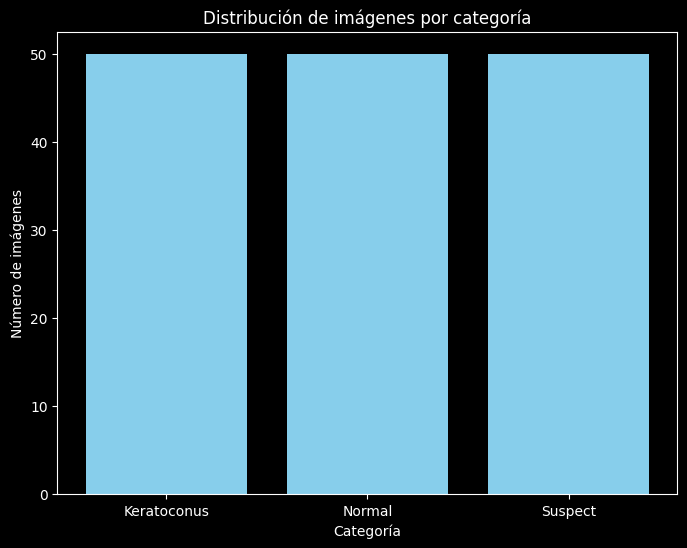

In [2]:
base_dir = r"Datos\Independent Test Set"

#creamos una lista que nos permitirá ver la cantidad de imágenes por cada categoría
num_images_per_category = []

#Obtenemos la cantidad de impagenes que hay en cada una de las categorías, las cuales están como folders y vamos iterando para ver la cantidad por folder
folders = ["Keratoconus", "Normal", "Suspect"]
for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    num_images = len(os.listdir(folder_path))
    num_images_per_category.append(num_images)

#Etiquetas para las categorías, las cuales son las 4 que ya se mencionaron
labels =  ["Keratoconus", "Normal", "Suspect"]

#gráfica de distribución para ver la cantidad
plt.figure(figsize=(8, 6))
plt.bar(labels, num_images_per_category, color='skyblue')
plt.xlabel('Categoría')
plt.ylabel('Número de imágenes')
plt.title('Distribución de imágenes por categoría')
plt.show()

In [3]:
for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    num_images = len(os.listdir(folder_path))
    print(f"Número de imágenes en '{folder}':", num_images)

Número de imágenes en 'Keratoconus': 50
Número de imágenes en 'Normal': 50
Número de imágenes en 'Suspect': 50


In [6]:
#Creamos una lista donde se va a estar almacenando el tamaño de las imágenes, es decir, largo y ancho
image_sizes = []


#vamos a hacer primero una iteración en cada folder, de nuevo
for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    #y ahora vamos a iterar en cada imagen de cada folder, obteniendo la dirección del folder y el nombre de la imágen, realmente el nombre no es muy útil
    #pero la función necesitaba dos parámetros y ps colocamos este para no tener problemas xd
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        #una vez que se tenga una imgaen, calculamos el largo y ancho y lo agregamos a la lista creada arriba
        with Image.open(image_path) as img:
            width, height = img.size
            image_sizes.append((width, height))

#Separar los tamaños de ancho y largo, la primera entrada es el ancho de la imagen y la segunda entrada el alto
widths = [size[0] for size in image_sizes]
heights = [size[1] for size in image_sizes]

#para poder ver si hay diferencias entre los tamaños, hacemos una gráfica que nos muestre todos los tamaños de todas las imágenes, pequeño spoiler de nuevo, todas son
#el mismo tamaño, es una muy buena base para empezar
plt.figure(figsize=(10, 6))
plt.scatter(widths, heights, color='skyblue', alpha=0.5)
plt.title('Tamaño de todas las imágenes')
plt.xlabel('Ancho (píxeles)')
plt.ylabel('Alto (píxeles)')
plt.grid(True)
plt.show()

PermissionError: [Errno 13] Permission denied: 'Datos\\Independent Test Set\\Keratoconus\\case1'